In [1]:
DATADIR = './original' # unzipped train and test data
OUTDIR = './model-output' # just a random name
# Data Loading
import os
import re
from glob import glob
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from tqdm import tqdm

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
%matplotlib inline


POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}


def load_data(data_dir):
    """ Return 2 lists of tuples:
    [(class_id, user_id, path), ...] for train
    [(class_id, user_id, path), ...] for validation
    """
    # Just a simple regexp for paths with three groups:
    # prefix, label, user_id
    pattern = re.compile("(.+\/)?(\w+)\/([^_]+)_.+wav")
    all_files = glob(os.path.join(data_dir, 'train/audio/*/*wav'))

    with open(os.path.join(data_dir, 'train/validation_list.txt'), 'r') as fin:
        validation_files = fin.readlines()
    valset = set()
    for entry in validation_files:
        r = re.match(pattern, entry)
        if r:
            valset.add(r.group(3))

    possible = set(POSSIBLE_LABELS)
    train, val = [], []
    for entry in all_files:
        r = re.match(pattern, entry)
        if r:
            label, uid = r.group(2), r.group(3)
            if label == '_background_noise_':
                label = 'silence'
            if label not in possible:
                label = 'unknown'

            label_id = name2id[label]

            sample = (label_id, uid, entry)
            if uid in valset:
                val.append(sample)
            else:
                train.append(sample)

    print('There are {} train and {} val samples'.format(len(train), len(val)))
    return train, val

trainset, valset = load_data(DATADIR)

There are 57929 train and 6798 val samples


In [2]:
df = pd.DataFrame(trainset)

def getMedianSlopeForLabel(df, label, silence_threshold = 0.1):
    df['label'] = df[2].map(lambda path: path.split('/')[4])
    df = df.loc[df['label'] == label]
    a = []
    for i in tqdm(range(df.shape[0])):
        filename = df.iloc[i, 2]
        sample_rate, wav = wavfile.read(filename)
        abs_wav = np.abs(wav)
        max_amp = abs_wav.max()
        wav = wav * (abs_wav > (silence_threshold * max_amp))
        x = range(0, len(wav))
        a = a + [np.polyfit(x, abs(wav), deg=1)[0]]
    return np.median(a)

median_dict = {}

for label in '_background_noise_'.split():
    median_dict[label] = getMedianSlopeForLabel(df, label, 0.0)
median_dict

  0%|          | 0/6 [00:00<?, ?it/s]/home/dannyp/Installed/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
100%|██████████| 6/6 [00:01<00:00,  3.83it/s]


{'_background_noise_': 3.0613266534128915e-05}

In [14]:
df = pd.DataFrame(trainset)

df['label'] = df[2].map(lambda path: path.split('/')[4])
df_silence = df.loc[df['label'] == '_background_noise_']
df_silence = df_silence.reset_index()
df_silence

,index,0,1,2,label
0,51560,10,exercise,./original/train/audio/_background_noise_/exer...,_background_noise_
1,51561,10,dude,./original/train/audio/_background_noise_/dude...,_background_noise_
2,51562,10,white,./original/train/audio/_background_noise_/whit...,_background_noise_
3,51563,10,doing,./original/train/audio/_background_noise_/doin...,_background_noise_
4,51564,10,pink,./original/train/audio/_background_noise_/pink...,_background_noise_
5,51565,10,running,./original/train/audio/_background_noise_/runn...,_background_noise_


In [26]:
a = [1, 2, 3, 4]
a[::-1]

[4, 3, 2, 1]

  0%|          | 0/6 [00:00<?, ?it/s]/home/dannyp/Installed/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


0.000895828001024


 17%|█▋        | 1/6 [00:00<00:01,  3.41it/s]

0.0


 33%|███▎      | 2/6 [00:00<00:01,  3.14it/s]

0.0039368877224


 50%|█████     | 3/6 [00:00<00:00,  3.18it/s]

0.000313687218989


 67%|██████▋   | 4/6 [00:01<00:00,  2.92it/s]

0.0039368877224


 83%|████████▎ | 5/6 [00:01<00:00,  2.82it/s]

0.000982863980172


100%|██████████| 6/6 [00:02<00:00,  2.91it/s]


3


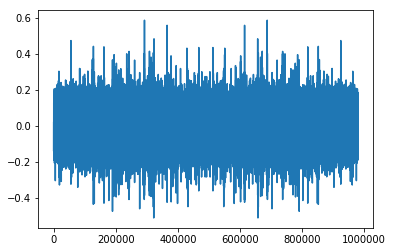

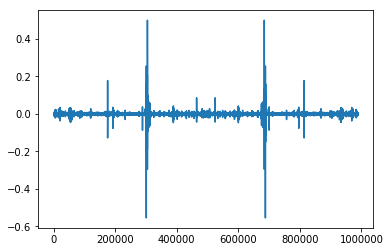

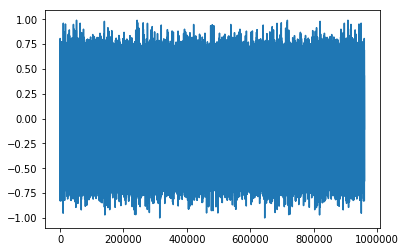

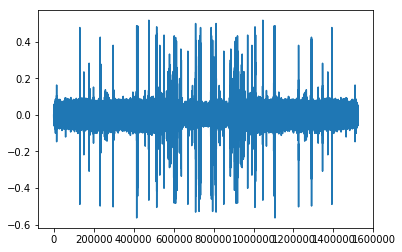

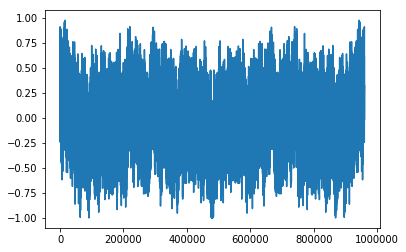

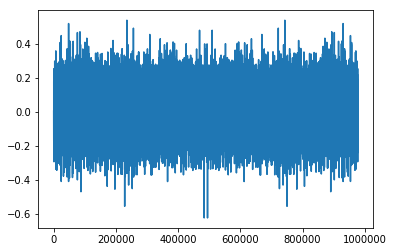

In [32]:
def isSilence(wav, threshold = 1e-5):
    x = range(0, len(wav))
    wav_norm = wav / np.max(wav)
    wav_thres = np.percentile(abs(wav_norm), 0.95)
    print(wav_thres)
    wav_norm = wav_norm * (abs(wav_norm) > wav_thres)
    wav_norm_2 = (wav_norm + wav_norm[::-1]) / 2
    plt.figure()
    #plt.plot(wav_norm)
    plt.plot(wav_norm_2)
    return np.polyfit(x, abs(wav), deg=1)[0] < threshold

c = 0

for i in tqdm(range(df_silence.shape[0])):
    sample_rate, wav = wavfile.read(df_silence.loc[i,2])
    c += isSilence(wav)
print(c)

In [47]:
print(c)

25643


In [7]:
import numpy as np
from scipy.io import wavfile

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

def plot_spectrogram(samples, sample_rate=16000):
    freqs, times, spectrogram = log_specgram(samples, sample_rate)

    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_title('Raw wave of ' + filename)
    ax1.set_ylabel('Amplitude')
    ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

    ax2 = fig.add_subplot(212)
    ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    ax2.set_yticks(freqs[::16])
    ax2.set_xticks(times[::16])
    ax2.set_title('Spectrogram of ' + filename)
    ax2.set_ylabel('Freqs in Hz')
    ax2.set_xlabel('Seconds')
    
plot_spectrogram(samples)

NameError: name 'samples' is not defined

In [17]:
ipd.Audio(samples, rate=sample_rate)

In [8]:
trainset_df = pd.DataFrame(trainset)
valset_df = pd.DataFrame(valset)

In [6]:

sample_rate, wav = wavfile.read('./original/test/audio/clip_0064f7bae.wav')
ipd.Audio(wav, rate=sample_rate)

/home/dannyp/Installed/anaconda3/lib/python3.6/site-packages/IPython/lib/display.py:135: RuntimeWarning: invalid value encountered in true_divide
  scaled = np.int16(data/np.max(np.abs(data))*32767).tolist()


NameError: name 'filename' is not defined

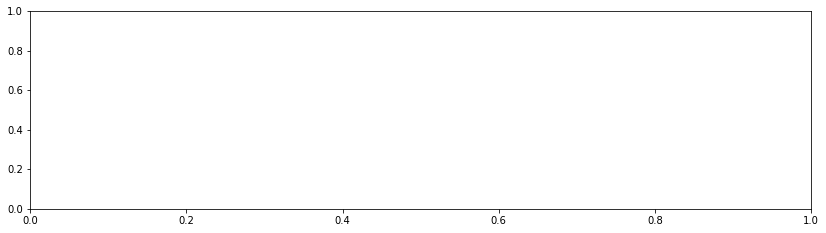

In [8]:
plot_spectrogram(wav)

In [11]:
from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank

filter_banks = logfbank(wav)
        

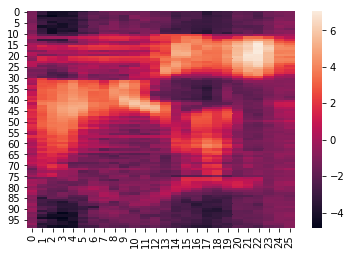

In [16]:
sns.heatmap(filter_banks)

In [15]:
filter_banks -= (np.mean(filter_banks, axis=0) + 1e-8)

In [19]:
filter_banks.shape

(99, 26)

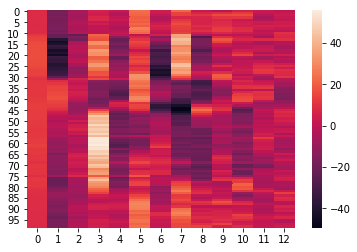

In [26]:
sns.heatmap(mfcc(wav))